# Collecting data from API and Storing in MongoDB

In [1]:
import pandas as pd
import http.client
import json
import pymongo
from datetime import datetime
import time

# Sleep for 5 seconds


for i in range(3):
    conn = http.client.HTTPSConnection("air-quality.p.rapidapi.com")

    headers = {
        'X-RapidAPI-Key': "7b57a8978emsh04ce45e97807a61p110210jsn118d5a2a54b0",
        'X-RapidAPI-Host': "air-quality.p.rapidapi.com"
    }

    conn.request("GET", "/history/airquality?lon=6.2603&lat=53.3498", headers=headers)
    
    res = conn.getresponse()
    data = res.read()
    
    string_data = data.decode('utf-8')
    
    # Parse string data to dictionary
    dictionary = json.loads(string_data)
    
    
    inner_dict=dictionary.pop("data")
    # Sample list of dictionaries
    data_1=inner_dict
    # Connect to MongoDB
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client["dap_api"]
    
    # Create a collection (table) named "customers"
    collection = db["api"]
    #collection.delete_many({})
    
    # Insert each dictionary as a document into the collection
    for item in inner_dict:
        item["timestamp_utc"]=datetime.utcnow()
        #only for first time
        item.pop("timestamp_local")
        item.pop("ts")
        item.pop("datetime")
        #print(item)
        collection.insert_one(item)
        
    time.sleep(5)
    # Verify that the documents were inserted
print(collection.count_documents({}))


720


# Retrieving API data from MongoDB

In [3]:
import pymongo
import pandas as pd

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["dap_api"]
collection = db["api"]
    
# Find all documents in the collection
cursor = collection.find()
    
# Iterate over the cursor to access each document
    
    
list_api=list(cursor)
df=pd.DataFrame(list_api)
df['timestamp_column'] = pd.to_datetime(df['timestamp_utc'])
df

,timestamp_utc,aqi,_id,o3,no2,so2,pm10,co,pm25,timestamp_column
0,2024-04-23 11:17:39.481,49,662798d3bb2fd391260bb64e,75.3,3.7,24.3,15.7,54.3,11.67,2024-04-23 11:17:39.481
1,2024-04-23 11:17:39.481,51,662798d3bb2fd391260bb64f,58.6,5.3,24.7,14.3,54.3,12.33,2024-04-23 11:17:39.481
2,2024-04-23 11:17:39.482,52,662798d3bb2fd391260bb650,41.9,7.0,25.0,13.0,54.3,13.00,2024-04-23 11:17:39.482
3,2024-04-23 11:17:39.483,42,662798d3bb2fd391260bb651,32.1,16.0,19.7,12.0,59.3,10.00,2024-04-23 11:17:39.483
4,2024-04-23 11:17:39.484,52,662798d3bb2fd391260bb652,19.7,21.0,14.3,13.0,64.4,13.00,2024-04-23 11:17:39.484
...,...,...,...,...,...,...,...,...,...,...
931,2024-04-30 10:38:07.124,17,6630ca0ffd425b13b07a0562,29.8,19.0,9.0,6.5,61.3,4.00,2024-04-30 10:38:07.124
932,2024-04-30 10:38:07.124,14,6630ca0ffd425b13b07a0563,29.2,21.0,10.0,9.0,62.4,3.00,2024-04-30 10:38:07.124
933,2024-04-30 10:38:07.125,23,6630ca0ffd425b13b07a0564,50.6,22.0,1.0,17.7,63.6,5.00,2024-04-30 10:38:07.125
934,2024-04-30 10:38:07.125,46,6630ca0ffd425b13b07a0565,26.1,47.0,12.0,11.0,64.8,11.00,2024-04-30 10:38:07.125


# Applying Dagster process to split data into date , hours, Minutes and seconds

In [8]:
import dagster
from dagster import job, op, JobDefinition
from pymongo import MongoClient
import xml.etree.ElementTree as ET
import pandas as pd

@op
def extract_data_from_mongodb(context):
    # Connect to MongoDB
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client["dap_api"]
    collection = db["api"]
    
    # Find all documents in the collection
    cursor = collection.find()
    
    # Iterate over the cursor to access each document
    
    
    list_api=list(cursor)
    df=pd.DataFrame(list_api)
    return df

@op
def extract_date(context, api_list):
    # Parse the XML data
    df['date'] = df['timestamp_column'].dt.date
    

@op
def extract_hours(context, api_list):
    df['Hours'] = df['timestamp_column'].dt.strftime('%H')    

@op
def extract_mins(context, api_list):
   df['Minutes'] = df['timestamp_column'].dt.strftime('%M') 

@op
def extract_sec(context, api_list):
   df['seconds'] = df['timestamp_column'].dt.strftime('%S')
@op
def print_df(context, api_list):
   df.head()


@job
def my_dagster_pipeline():
    api_df = extract_data_from_mongodb()
    extract_date(api_df)
    extract_hours(api_df)
    extract_mins(api_df)
    extract_sec(api_df)
    print_df(api_df)
# Run the pipeline
if __name__ == "__main__":
    JobDefinition.execute_in_process(my_dagster_pipeline)


2024-04-24 13:15:49 +0100 - dagster - DEBUG - my_dagster_pipeline - f7c1f081-7680-495e-b513-23d9f1319804 - 7792 - RUN_START - Started execution of run for "my_dagster_pipeline".
2024-04-24 13:15:49 +0100 - dagster - DEBUG - my_dagster_pipeline - f7c1f081-7680-495e-b513-23d9f1319804 - 7792 - ENGINE_EVENT - Executing steps in process (pid: 7792)
2024-04-24 13:15:49 +0100 - dagster - DEBUG - my_dagster_pipeline - f7c1f081-7680-495e-b513-23d9f1319804 - 7792 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2024-04-24 13:15:49 +0100 - dagster - DEBUG - my_dagster_pipeline - f7c1f081-7680-495e-b513-23d9f1319804 - 7792 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2024-04-24 13:15:49 +0100 - dagster - DEBUG - my_dagster_pipeline - f7c1f081-7680-495e-b513-23d9f1319804 - 7792 - LOGS_CAPTURED - Started capturing logs in process (pid: 7792).
2024-04-24 13:15:49 +0100 - dagster - DEBUG - my_dagster_pipeline - f7c1f081-7680-495e-b513-23d9f13

## Printing the data

In [9]:
df

,timestamp_utc,aqi,_id,o3,no2,so2,pm10,co,pm25,timestamp_column,date,time,Hours,Minutes,seconds
0,2024-04-23 11:17:39.481,49,662798d3bb2fd391260bb64e,75.3,3.7,24.3,15.7,54.3,11.67,2024-04-23 11:17:39.481,2024-04-23,1,11,17,39
1,2024-04-23 11:17:39.481,51,662798d3bb2fd391260bb64f,58.6,5.3,24.7,14.3,54.3,12.33,2024-04-23 11:17:39.481,2024-04-23,1,11,17,39
2,2024-04-23 11:17:39.482,52,662798d3bb2fd391260bb650,41.9,7.0,25.0,13.0,54.3,13.00,2024-04-23 11:17:39.482,2024-04-23,1,11,17,39
3,2024-04-23 11:17:39.483,42,662798d3bb2fd391260bb651,32.1,16.0,19.7,12.0,59.3,10.00,2024-04-23 11:17:39.483,2024-04-23,1,11,17,39
4,2024-04-23 11:17:39.484,52,662798d3bb2fd391260bb652,19.7,21.0,14.3,13.0,64.4,13.00,2024-04-23 11:17:39.484,2024-04-23,1,11,17,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2024-04-24 12:03:18.295,29,6628f506d4b2a9a3f235226d,62.7,5.0,0.0,6.3,54.1,3.00,2024-04-24 12:03:18.295,2024-04-24,1,12,03,18
716,2024-04-24 12:03:18.296,33,6628f506d4b2a9a3f235226e,72.0,8.0,0.0,8.0,53.3,3.50,2024-04-24 12:03:18.296,2024-04-24,1,12,03,18
717,2024-04-24 12:03:18.297,43,6628f506d4b2a9a3f235226f,92.0,8.0,1.0,8.0,52.5,3.00,2024-04-24 12:03:18.297,2024-04-24,1,12,03,18
718,2024-04-24 12:03:18.297,18,6628f506d4b2a9a3f2352270,39.2,11.0,2.0,15.0,52.7,3.00,2024-04-24 12:03:18.297,2024-04-24,1,12,03,18


## Dropping unnessasary columns

In [10]:
import re
df2=df.drop(["timestamp_column","timestamp_utc","time","_id"],axis=1)


## Writing to CSV

In [11]:
import csv

def writing_to_csv():
 
    try:
        csv_file=open("Output CSV.csv","w")
        
    except FileNotFoundError:
        ##print if file not found
        print("please enter the correct file")
    except PermissionError:
        ##print if you dont have the exact permissions
        print("sorry you dont have the right permissions")
    except Exception as error:
        ##print any other array
        print("an error was raised\n",error)

df2.to_csv("Output CSV.csv", sep=',', index=False)
writing_to_csv

<function __main__.writing_to_csv()>

# Creating Database

In [13]:
import psycopg2
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "postgres")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute('CREATE DATABASE air_quality_2;')
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


Error while connecting to PostgreSQL database "air_quality_2" already exists



# creating table

In [14]:
table_create_string = """
CREATE TABLE air_quality3(
id_column UUID DEFAULT uuid_generate_v4() PRIMARY KEY,
datetime Timestamp ,
pm10 numeric(5,1),
so2 numeric(5,1),
co numeric(5,1),
aqi numeric(5,1),
pm25 numeric(5,1),
o3 numeric(5,1),
no2 numeric(7,1),
hours int,
minutes int,
seconds int
)
"""


try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute("CREATE EXTENSION IF NOT EXISTS \"uuid-ossp\";")
    dbCursor.execute(table_create_string)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


Error while connecting to PostgreSQL relation "air_quality3" already exists



# checking if table has previous contents(only used during project development)

In [16]:
table_select_string="select * from air_quality3"
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(table_select_string)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


## Dropping data incase it existed(used during project development only)

In [17]:
table_select_string="delete from air_quality3"
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(table_select_string)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


## Inserting into table

In [18]:
import csv
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2"
    )
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    insertString = """INSERT INTO air_quality3 (o3,so2,no2,co,pm10,aqi,pm25,datetime,hours,minutes,seconds) VALUES ({},{},{},{},{},{},{},TO_TIMESTAMP('{}',
'YYYY/MM/DD'),{},{},{})"""
    # ensure you change the path below to match your download location
    with open('Output CSV.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            dbCursor.execute(insertString.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10]))
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


## Extracting data from table

In [19]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
sql = """
SELECT
* FROM
air_quality3;"""



try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2"
    )
    air_quality = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()

air_quality

C:\Users\vishw\AppData\Local\Temp\ipykernel_7792\2165928812.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  air_quality = sqlio.read_sql_query(sql, dbConnection)


,id_column,datetime,pm10,so2,co,aqi,pm25,o3,no2,hours,minutes,seconds
0,d0758c61-3f97-4c01-90e1-9deb2b9aef84,2024-04-23,15.7,75.3,24.3,54.3,11.7,49.0,3.7,11,17,39
1,e4480ae3-be6b-4ced-955f-31b68e8144f8,2024-04-23,14.3,58.6,24.7,54.3,12.3,51.0,5.3,11,17,39
2,d9115301-2946-415c-89d2-5f41dc2ac7d5,2024-04-23,13.0,41.9,25.0,54.3,13.0,52.0,7.0,11,17,39
3,20b1471a-5754-478e-beb0-cd91d4bd253a,2024-04-23,12.0,32.1,19.7,59.3,10.0,42.0,16.0,11,17,39
4,cc5ce014-48a3-411f-8c28-2bf5c3033062,2024-04-23,13.0,19.7,14.3,64.4,13.0,52.0,21.0,11,17,39
...,...,...,...,...,...,...,...,...,...,...,...,...
715,c51e1ebd-e24f-4181-8883-971deb8c3d4f,2024-04-24,6.3,62.7,0.0,54.1,3.0,29.0,5.0,12,3,18
716,597c3bf1-a442-4969-9ed5-6c575adda84f,2024-04-24,8.0,72.0,0.0,53.3,3.5,33.0,8.0,12,3,18
717,161fb651-1e7c-4b96-ab29-a3228b638a1c,2024-04-24,8.0,92.0,1.0,52.5,3.0,43.0,8.0,12,3,18
718,5a05d129-6e50-45dc-8fd7-a6865fb030ea,2024-04-24,15.0,39.2,2.0,52.7,3.0,18.0,11.0,12,3,18


# Extracting data from XML format

In [212]:
import xml.etree.ElementTree as ET

# Function to print XML file in an organized way
def print_xml_file(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    print("XML Data:")
    print(prettify(root, depth=0, max_elements=5))  # Pretty print the XML data with limit

# Function to prettify XML data with a limit on the number of elements printed
def prettify(elem, depth=0, max_elements=None):
    """
    Return a pretty-printed XML string for the Element with a limit on the number of elements printed.
    """
    if max_elements is not None and depth >= max_elements:
        return ""
    indent = "  "
    i = "\n" + depth * indent
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + indent
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        if max_elements is not None:
            children = elem[:max_elements - 1]  # Limit the number of children to print
        else:
            children = elem
        parts = [prettify(child, depth + 1, max_elements) for child in children]
        if max_elements is not None and len(elem) > max_elements:
            parts.append("\n" + (depth + 1) * indent + "...")  # Add indication of truncation
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        return "<{}>{}{}</{}>".format(elem.tag, "".join(parts), i, elem.tag)
    else:
        if depth and (not elem.tail or not elem.tail.strip()):
            elem.tail = i
        return ET.tostring(elem, encoding='unicode')

# Example usage
xml_file_path = 'air_quality.xml'  # Replace with your XML file path

print_xml_file(xml_file_path)


XML Data:
<Records><Record><Row A="Date" B="Time" C="CO(GT)" D="PT08.S1(CO)" E="NMHC(GT)" F="C6H6(GT)" G="PT08.S2(NMHC)" H="NOx(GT)" I="PT08.S3(NOx)" J="NO2(GT)" K="PT08.S4(NO2)" L="PT08.S5(O3)" M="T" N="RH" O="AH" />
    
  </Record><Record><Row A="10/3/2004" B="18.00.00" C="2" D="6" E="1360" F="150" G="11" H="9" I="1046" J="166" K="1056" L="113" M="1692" N="1268" O="13" P="6" Q="48" R="9" S="0" T="7578" />
    
  </Record><Record><Row A="1/1/2005" B="10.00.00" C="1" D="2" E="973" F="-200" G="4" H="7" I="748" J="190" K="878" L="97" M="968" N="991" O="4" P="7" Q="57" R="2" S="0" T="4932" />
    
  </Record><Record><Row A="10/3/2004" B="20.00.00" C="2" D="2" E="1402" F="88" G="9" H="0" I="939" J="131" K="1140" L="114" M="1555" N="1074" O="11" P="9" Q="54" R="0" S="0" T="7502" />
    
  </Record>
  ...
</Records>


In [217]:
import xml.etree.ElementTree as ET
import pandas as pd

# Parse the XML file
tree = ET.parse('air_quality.xml')
root = tree.getroot()

# Extract column names from the first Record element
columns = [attr for attr in root.findall('./Record[1]/Row')[0].attrib.keys()]

# Define an empty list to store the data
data = []

# Iterate over Record elements and extract data
for record in root.findall('./Record'):
    row_data = [record.find('./Row').attrib.get(col) for col in columns]
    data.append(row_data)

# Convert the list of lists to a DataFrame
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
print(df)


              A         B       C            D         E         F  \
0          Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)   
1     10/3/2004  18.00.00       2            6      1360       150   
2      1/1/2005  10.00.00       1            2       973      -200   
3     10/3/2004  20.00.00       2            2      1402        88   
4     10/3/2004  21.00.00       2            2      1376        80   
...         ...       ...     ...          ...       ...       ...   
9353   4/4/2005  10.00.00       3            1      1314      -200   
9354   4/4/2005  11.00.00       2            4      1163      -200   
9355   4/4/2005  12.00.00       2            4      1142      -200   
9356   4/4/2005  13.00.00       2            1      1003      -200   
9357   4/4/2005  14.00.00       2            2      1071      -200   

                  G        H             I        J             K  \
0     PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)   
1                11  

In [218]:
import pandas as pd

# Assuming df is your DataFrame
# Extract the first row as the new column names
new_columns = df.iloc[0]

# Assign the new column names to the DataFrame
df.columns = new_columns

# Drop the first row from the DataFrame
df = df.drop(df.index[0])

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

# Display the updated DataFrame
print(df)


0          Date      Time CO(GT) PT08.S1(CO) NMHC(GT) C6H6(GT) PT08.S2(NMHC)  \
0     10/3/2004  18.00.00      2           6     1360      150            11   
1      1/1/2005  10.00.00      1           2      973     -200             4   
2     10/3/2004  20.00.00      2           2     1402       88             9   
3     10/3/2004  21.00.00      2           2     1376       80             9   
4     10/3/2004  22.00.00      1           6     1272       51             6   
...         ...       ...    ...         ...      ...      ...           ...   
9352   4/4/2005  10.00.00      3           1     1314     -200            13   
9353   4/4/2005  11.00.00      2           4     1163     -200            11   
9354   4/4/2005  12.00.00      2           4     1142     -200            12   
9355   4/4/2005  13.00.00      2           1     1003     -200             9   
9356   4/4/2005  14.00.00      2           2     1071     -200            11   

0    NOx(GT) PT08.S3(NOx) NO2(GT) PT08.

## Converting XML format to dataframe

# Inserting XML data into MongoDB

In [219]:
import pandas as pd
from pymongo import MongoClient
data=df
# Convert DataFrame to dictionary records
data = data.to_dict(orient='records')

# Initialize MongoDB client and connect to the MongoDB server
client = MongoClient('localhost', 27017)

# Select the database
db = client['dap_api']

# Select the collection (table)
collection = db['new xml data']

# Insert the data into MongoDB collection
collection.insert_many(data)

print("DataFrame has been successfully transferred to MongoDB.")


DataFrame has been successfully transferred to MongoDB.


In [238]:
client = MongoClient("mongodb://localhost:27017/")
db = client["dap_api"]  # Specify the name of your database

# Specify the name of your collection
collection_name = "new xml data"

# Extract data from MongoDB
collection = db[collection_name]
document = collection.find()

list_xml=list(document)
df_xml=pd.DataFrame(list_xml)
df_xml.head()

,_id,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,662bc5ebd4b2a9a3f235a64b,10/3/2004,18.00.00,2,6,1360,150,11,9,1046,166,1056,113,1692,1268,13
1,662bc5ebd4b2a9a3f235a64c,1/1/2005,10.00.00,1,2,973,-200,4,7,748,190,878,97,968,991,4
2,662bc5ebd4b2a9a3f235a64d,10/3/2004,20.00.00,2,2,1402,88,9,0,939,131,1140,114,1555,1074,11
3,662bc5ebd4b2a9a3f235a64e,10/3/2004,21.00.00,2,2,1376,80,9,2,948,172,1092,122,1584,1203,11
4,662bc5ebd4b2a9a3f235a64f,10/3/2004,22.00.00,1,6,1272,51,6,5,836,131,1205,116,1490,1110,11


## ETL process for XML data

In [272]:
import dagster
from dagster import job, op, JobDefinition
from pymongo import MongoClient
import xml.etree.ElementTree as ET

@op
def extract_data_from_mongodb(context):
    client = MongoClient("mongodb://localhost:27017/")
    db = client["dap_api"]  # Specify the name of your database
    
    # Specify the name of your collection
    collection_name = "new xml data"
    
    # Extract data from MongoDB
    collection = db[collection_name]
    document = collection.find()
    
    list_xml=list(document)
    df_xml=pd.DataFrame(list_xml)
    
    return df_xml


@job
def my_dagster_pipeline():
    df_xml=extract_data_from_mongodb()
    

# Run the pipeline
if __name__ == "__main__":
    JobDefinition.execute_in_process(my_dagster_pipeline)
    

2024-04-27 15:07:04 +0100 - dagster - DEBUG - my_dagster_pipeline - 3784adf4-4923-4295-9fe6-e0dfef928957 - 7792 - RUN_START - Started execution of run for "my_dagster_pipeline".
2024-04-27 15:07:04 +0100 - dagster - DEBUG - my_dagster_pipeline - 3784adf4-4923-4295-9fe6-e0dfef928957 - 7792 - ENGINE_EVENT - Executing steps in process (pid: 7792)
2024-04-27 15:07:04 +0100 - dagster - DEBUG - my_dagster_pipeline - 3784adf4-4923-4295-9fe6-e0dfef928957 - 7792 - extract_data_from_mongodb - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2024-04-27 15:07:04 +0100 - dagster - DEBUG - my_dagster_pipeline - 3784adf4-4923-4295-9fe6-e0dfef928957 - 7792 - extract_data_from_mongodb - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2024-04-27 15:07:04 +0100 - dagster - DEBUG - my_dagster_pipeline - 3784adf4-4923-4295-9fe6-e0dfef928957 - 7792 - LOGS_CAPTURED - Started capturing logs in process (pid: 7792).
2024-04-27 15:07:04 +0100 - dagster - DEBUG

In [273]:
df_xml.head()
df_xml=df_xml.drop(["_id","Time","CO(GT)","PT08.S1(CO)","NMHC(GT)","C6H6(GT)","PT08.S2(NMHC)","NOx(GT)"],axis=1)

In [277]:
df_xml["NO"]=df_xml["PT08.S3(NOx)"]
df_xml["NO2"]=df_xml["NO2(GT)"]
df_xml["Particle NO2"]=df_xml["PT08.S4(NO2)"]
df_xml["O3"]=df_xml["PT08.S5(O3)"]
df_xml.head()

,Date,PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,NO,NO2,Particle NO2,O3
0,10/3/2004,1046,166,1056,113,1692,1268,13,1046,166,1056,113
1,1/1/2005,748,190,878,97,968,991,4,748,190,878,97
2,10/3/2004,939,131,1140,114,1555,1074,11,939,131,1140,114
3,10/3/2004,948,172,1092,122,1584,1203,11,948,172,1092,122
4,10/3/2004,836,131,1205,116,1490,1110,11,836,131,1205,116


In [279]:
df_xml=df_xml.drop(["PT08.S3(NOx)","NO2(GT)","PT08.S4(NO2)","PT08.S5(O3)"],axis=1)
df_xml.head()

,Date,T,RH,AH,NO,NO2,Particle NO2,O3
0,10/3/2004,1692,1268,13,1046,166,1056,113
1,1/1/2005,968,991,4,748,190,878,97
2,10/3/2004,1555,1074,11,939,131,1140,114
3,10/3/2004,1584,1203,11,948,172,1092,122
4,10/3/2004,1490,1110,11,836,131,1205,116


In [285]:
df_xml.to_csv("xml_csv.csv",index=False)

In [280]:
table_create_string = """
CREATE TABLE xml_air(
id_column UUID DEFAULT uuid_generate_v4() PRIMARY KEY,
date timestamp,
T int,
RH int,
AH int,
NO int,
NO2 int,
particleNO2 int,
O3 int
)
"""


try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute("CREATE EXTENSION IF NOT EXISTS \"uuid-ossp\";")
    dbCursor.execute(table_create_string)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


In [281]:
table_select_string="delete from xml_air"
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(table_select_string)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


In [288]:
import csv
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2"
    )
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    insertString = """INSERT INTO xml_air (date,T,RH,AH,NO,NO2,particleNO2,O3) VALUES (TO_TIMESTAMP('{}','DD/MM/YYYY'),{},{},{},{},{},{},{})"""
    # ensure you change the path below to match your download location
    with open('xml_csv.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            dbCursor.execute(insertString.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7]))
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


In [289]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
sql = """
SELECT
* FROM
xml_air;"""



try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2"
    )
    air_quality = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()

air_quality

C:\Users\vishw\AppData\Local\Temp\ipykernel_7792\1154779755.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  air_quality = sqlio.read_sql_query(sql, dbConnection)


,id_column,date,t,rh,ah,no,no2,particleno2,o3
0,aef3cb90-a655-4959-be9f-a4afe92052dc,2004-03-10,1692,1268,13,1046,166,1056,113
1,baaa127c-e3af-442a-b674-6aea45e0048c,2005-01-01,968,991,4,748,190,878,97
2,1c734593-94ff-4ac9-bfe8-7c9f4e057042,2004-03-10,1555,1074,11,939,131,1140,114
3,79c88f10-29e0-4add-a2b4-45cd30391ab5,2004-03-10,1584,1203,11,948,172,1092,122
4,45cdb7f4-7d0a-4c37-873d-c7e41bac9939,2004-03-10,1490,1110,11,836,131,1205,116
...,...,...,...,...,...,...,...,...,...
9352,6775c252-4ef3-4da2-bc4c-933b83381bbf,2005-04-04,1374,1729,21,1101,472,539,190
9353,80ae38b0-5919-4add-ac54-c8817f10a9c9,2005-04-04,1264,1269,24,1027,353,604,179
9354,4f781012-0044-44e2-b89d-e57b3bf994d2,2005-04-04,1241,1092,26,1063,293,603,175
9355,6d6eeacb-7f15-4cdf-a125-81a4ccafb79d,2005-04-04,1041,770,28,961,235,702,156


# extracting data from csv file

In [133]:
import pandas as pd

csv_file=pd.read_csv("air_quality_data.csv")
csv_file.head()

,City,Date,PM2.5,PM10,NO2,SO2,O3,AQI,AQI_Bucket
0,Delhi,2022-01-13,230.50,355.43,61.28,24.28,75.14,370.0,Very Poor
1,Delhi,2022-01-14,191.47,308.74,54.37,22.47,64.80,365.0,Very Poor
2,Delhi,2022-01-15,177.71,309.85,52.51,19.12,59.73,352.0,Very Poor
3,Delhi,2022-01-16,133.56,231.04,46.86,19.06,54.00,278.0,Poor
4,Delhi,2022-01-17,235.06,353.55,47.86,14.48,64.10,350.0,Very Poor


In [135]:
import pandas as pd
import dagster
from dagster import job, op, JobDefinition
from pymongo import MongoClient
import xml.etree.ElementTree as ET

air_quality=pd.read_csv("air_quality_data.csv")
air_quality.head()
air_dict = air_quality.to_dict(orient='records')

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["dap_api"]
collection = db["csv_data"]


collection.insert_many(air_dict)

    


InsertManyResult([ObjectId('662a3cc5d4b2a9a3f2359935'), ObjectId('662a3cc5d4b2a9a3f2359936'), ObjectId('662a3cc5d4b2a9a3f2359937'), ObjectId('662a3cc5d4b2a9a3f2359938'), ObjectId('662a3cc5d4b2a9a3f2359939'), ObjectId('662a3cc5d4b2a9a3f235993a'), ObjectId('662a3cc5d4b2a9a3f235993b'), ObjectId('662a3cc5d4b2a9a3f235993c'), ObjectId('662a3cc5d4b2a9a3f235993d'), ObjectId('662a3cc5d4b2a9a3f235993e'), ObjectId('662a3cc5d4b2a9a3f235993f'), ObjectId('662a3cc5d4b2a9a3f2359940'), ObjectId('662a3cc5d4b2a9a3f2359941'), ObjectId('662a3cc5d4b2a9a3f2359942'), ObjectId('662a3cc5d4b2a9a3f2359943'), ObjectId('662a3cc5d4b2a9a3f2359944'), ObjectId('662a3cc5d4b2a9a3f2359945'), ObjectId('662a3cc5d4b2a9a3f2359946'), ObjectId('662a3cc5d4b2a9a3f2359947'), ObjectId('662a3cc5d4b2a9a3f2359948'), ObjectId('662a3cc5d4b2a9a3f2359949'), ObjectId('662a3cc5d4b2a9a3f235994a'), ObjectId('662a3cc5d4b2a9a3f235994b'), ObjectId('662a3cc5d4b2a9a3f235994c'), ObjectId('662a3cc5d4b2a9a3f235994d'), ObjectId('662a3cc5d4b2a9a3f23599

In [37]:
import dagster
from dagster import job, op, JobDefinition
from pymongo import MongoClient
import xml.etree.ElementTree as ET

@op
def extract_data_from_mongodb(context):
    # Connect to MongoDB
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client["dap_api"]
    collection = db["csv_data"]
    
    # Find all documents in the collection
    cursor = collection.find()
    
    # Iterate over the cursor to access each document
    
    
    list_api=list(cursor)
    df=pd.DataFrame(list_api)
    return df


@job
def my_dagster_pipeline():
    csv_df = extract_data_from_mongodb()
    print(csv_df)
# Run the pipeline
if __name__ == "__main__":
    JobDefinition.execute_in_process(my_dagster_pipeline)


2024-04-24 13:27:29 +0100 - dagster - DEBUG - my_dagster_pipeline - 93fc0d8a-6d5d-4a2e-91ea-0c30b06b2d08 - 7792 - RUN_START - Started execution of run for "my_dagster_pipeline".
2024-04-24 13:27:29 +0100 - dagster - DEBUG - my_dagster_pipeline - 93fc0d8a-6d5d-4a2e-91ea-0c30b06b2d08 - 7792 - ENGINE_EVENT - Executing steps in process (pid: 7792)
2024-04-24 13:27:29 +0100 - dagster - DEBUG - my_dagster_pipeline - 93fc0d8a-6d5d-4a2e-91ea-0c30b06b2d08 - 7792 - extract_data_from_mongodb - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2024-04-24 13:27:29 +0100 - dagster - DEBUG - my_dagster_pipeline - 93fc0d8a-6d5d-4a2e-91ea-0c30b06b2d08 - 7792 - extract_data_from_mongodb - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2024-04-24 13:27:29 +0100 - dagster - DEBUG - my_dagster_pipeline - 93fc0d8a-6d5d-4a2e-91ea-0c30b06b2d08 - 7792 - LOGS_CAPTURED - Started capturing logs in process (pid: 7792).
2024-04-24 13:27:29 +0100 - dagster - DEBUG

In [136]:
air_quality.head()
air_quality.dropna(subset=['PM10'], inplace=True)
air_quality=air_quality.drop(["AQI_Bucket"],axis=1)
air_quality["pm25"]=air_quality["PM2.5"]
air_quality=air_quality.drop(["PM2.5","City"],axis=1)
air_quality.to_csv("air_quality_csv.csv",index=False)

In [122]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

table_create_string = """
CREATE TABLE air_quality_csv4(
id_column UUID DEFAULT uuid_generate_v4() PRIMARY KEY,
date Timestamp,
pm25 numeric(5,1),
pm10 numeric(5,1),
no2 numeric(5,1),
so2 numeric(5,1),
o3 numeric(5,1),
aqi numeric(7,1)
)
"""


try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute("CREATE EXTENSION IF NOT EXISTS \"uuid-ossp\";")
    dbCursor.execute(table_create_string)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


In [137]:
import csv
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2"
    )
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    insertString = """INSERT INTO air_quality_csv4 (date,pm25,pm10,no2,so2,o3,aqi) VALUES (TO_TIMESTAMP(%s,
'YYYY/MM/DD'),%s,%s,%s,%s,%s,%s)"""
    # ensure you change the path below to match your download location
    with open('air_quality_csv.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            dbCursor.execute(insertString,row)
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()


In [131]:
import numpy as np
import pandas as pd
np.where(pd.isnull(air_quality))

(array([2194, 2194, 2194, 2194, 2194, 2194, 2195, 2195, 2195, 2195, 2195,
        2195, 2196, 2196, 2196, 2196, 2196, 2196, 2841, 2841, 2841, 2841,
        2841, 2841, 2842, 2842, 2842, 2842, 2842, 2842, 2843, 2843, 2843,
        2843, 2843, 2843], dtype=int64),
 array([1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4,
        5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6], dtype=int64))

In [139]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
sql = """
SELECT
* FROM
air_quality_csv4;"""



try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2"
    )
    air_quality1 = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()

air_quality1

C:\Users\vishw\AppData\Local\Temp\ipykernel_7792\513324443.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  air_quality1 = sqlio.read_sql_query(sql, dbConnection)


,id_column,date,pm25,pm10,no2,so2,o3,aqi
0,a9a6a14e-612b-49b9-934e-c2d763362361,2022-01-13,355.4,61.3,24.3,75.1,370.0,230.5
1,70b057f9-7cb7-44b5-bd4d-5c4c27ea9326,2022-01-14,308.7,54.4,22.5,64.8,365.0,191.5
2,ffd47acb-9968-4b1d-8f2d-bdc7b70f168d,2022-01-15,309.9,52.5,19.1,59.7,352.0,177.7
3,4d222a2b-6b39-4c97-94d8-922f5a2f3654,2022-01-16,231.0,46.9,19.1,54.0,278.0,133.6
4,2787df37-7eb0-4488-8e34-4d67299f67ec,2022-01-17,353.6,47.9,14.5,64.1,350.0,235.1
...,...,...,...,...,...,...,...,...
14308,75022421-2820-4f63-8b84-8448ce25b1d5,2023-12-15,102.2,32.8,36.7,12.1,142.7,56.0
14309,9d30ba2e-bf2b-4ae5-8a92-254ac56b6ef6,2023-12-16,77.6,36.0,37.2,13.3,96.3,32.8
14310,ef56f941-21db-4cc2-802d-21847a398df3,2023-12-17,76.8,23.2,33.9,22.7,105.4,36.6
14311,ff827bce-04be-437a-98fd-2c79ae1bd2b4,2023-12-18,92.8,43.1,37.3,17.5,139.2,52.5


In [156]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
sql = """
SELECT date, pm25, pm10, no2, so2, o3, aqi FROM air_quality_csv4
UNION ALL
SELECT datetime, pm25, pm10, no2, so2, o3, aqi FROM air_quality3;
"""



try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "127.0.0.1",
    port = "5432",
    database = "air_quality_2"
    )
    air_quality2 = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if dbConnection in locals():
        dbConnection.close()

air_quality2

C:\Users\vishw\AppData\Local\Temp\ipykernel_7792\7915453.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  air_quality2 = sqlio.read_sql_query(sql, dbConnection)


,date,pm25,pm10,no2,so2,o3,aqi
0,2022-01-13,355.4,61.3,24.3,75.1,370.0,230.5
1,2022-01-14,308.7,54.4,22.5,64.8,365.0,191.5
2,2022-01-15,309.9,52.5,19.1,59.7,352.0,177.7
3,2022-01-16,231.0,46.9,19.1,54.0,278.0,133.6
4,2022-01-17,353.6,47.9,14.5,64.1,350.0,235.1
...,...,...,...,...,...,...,...
15028,2024-04-24,3.0,6.3,5.0,62.7,29.0,54.1
15029,2024-04-24,3.5,8.0,8.0,72.0,33.0,53.3
15030,2024-04-24,3.0,8.0,8.0,92.0,43.0,52.5
15031,2024-04-24,3.0,15.0,11.0,39.2,18.0,52.7


In [140]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model 
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model as lm
import sklearn.metrics as metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

In [157]:
air_quality2.head()

,date,pm25,pm10,no2,so2,o3,aqi
0,2022-01-13,355.4,61.3,24.3,75.1,370.0,230.5
1,2022-01-14,308.7,54.4,22.5,64.8,365.0,191.5
2,2022-01-15,309.9,52.5,19.1,59.7,352.0,177.7
3,2022-01-16,231.0,46.9,19.1,54.0,278.0,133.6
4,2022-01-17,353.6,47.9,14.5,64.1,350.0,235.1


In [158]:
print("shape \n")
print(air_quality2.shape)

shape 

(15033, 7)


In [159]:
print("Columns \n")
print(air_quality2.columns)

Columns 

Index(['date', 'pm25', 'pm10', 'no2', 'so2', 'o3', 'aqi'], dtype='object')


In [160]:
print("Describe \n")
print(air_quality2.describe())

Describe 

                                date          pm25          pm10  \
count                          15033  15033.000000  15033.000000   
mean   2023-01-18 11:02:51.702254848    117.067671     34.984900   
min              2022-01-12 00:00:00      1.000000      2.000000   
25%              2022-07-03 00:00:00     40.700000     17.000000   
50%              2023-01-12 00:00:00     86.600000     29.900000   
75%              2023-07-19 00:00:00    165.400000     46.100000   
max              2024-04-24 00:00:00    761.900000    275.200000   
std                              NaN    103.107016     25.108298   

                no2           so2            o3           aqi  
count  15033.000000  15033.000000  15033.000000  15033.000000  
mean      48.821506     50.138608    144.264718     68.276798  
min        1.000000      4.200000     12.000000      2.600000  
25%       10.200000     31.900000     70.000000     26.200000  
50%       17.200000     43.700000    122.600000     52.5

In [161]:
print("Info \n")
print(air_quality2.info())

Info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15033 entries, 0 to 15032
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    15033 non-null  datetime64[ns]
 1   pm25    15033 non-null  float64       
 2   pm10    15033 non-null  float64       
 3   no2     15033 non-null  float64       
 4   so2     15033 non-null  float64       
 5   o3      15033 non-null  float64       
 6   aqi     15033 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 822.2 KB
None


In [162]:
print("Checking the Datatypes \n")
print(air_quality2.dtypes)

Checking the Datatypes 

date    datetime64[ns]
pm25           float64
pm10           float64
no2            float64
so2            float64
o3             float64
aqi            float64
dtype: object


In [163]:
print("Counting the null values \n")
print(air_quality2.isnull().sum())

Counting the null values 

date    0
pm25    0
pm10    0
no2     0
so2     0
o3      0
aqi     0
dtype: int64


In [164]:
print("Counting the NAN values \n")
print(air_quality2.isna().sum())

Counting the NAN values 

date    0
pm25    0
pm10    0
no2     0
so2     0
o3      0
aqi     0
dtype: int64


In [172]:
import pandas as pd
from scipy.stats import skew

# Assuming you already have 'air_quality2' DataFrame defined

# Get the column names of air_quality2
columns = ['pm25','pm10','no2','so2','o3','aqi']

# Loop through each column and calculate skewness
for column in columns:
    skew_value = skew(air_quality2[column])
    print("Skewness of {}: \t{}".format(column, skew_value))


Skewness of pm25: 	1.488934944555144
Skewness of pm10: 	2.0405359297491956
Skewness of no2: 	2.932271952704939
Skewness of so2: 	0.7326159054501505
Skewness of o3: 	1.2998622280405139
Skewness of aqi: 	1.8941503343840247


In [4]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

columns=['pm25','pm10','no2','so2','o3','aqi']
# Flatten the 2D array of subplots to make indexing easier
axes = axes.flatten()

# Loop through each feature and plot a histogram
for i, column in enumerate(columns):
    ax = axes[i]
    sns.histplot(air_quality[column], color='pink', ax=ax)
    ax.set_title(f'Histogram - {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

plt.show()

NameError: name 'plt' is not defined

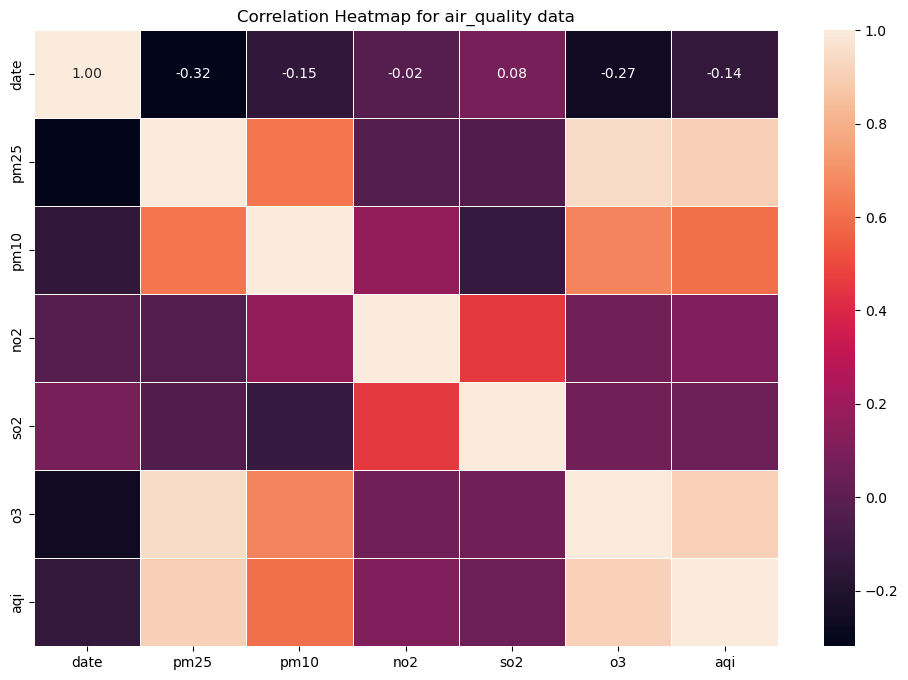

In [175]:
plt.figure(figsize=(12,8))
sns.heatmap(air_quality2.corr(),annot=True, fmt=".2f", linewidths=0.4)
plt.title('Correlation Heatmap for air_quality data')

plt.show()

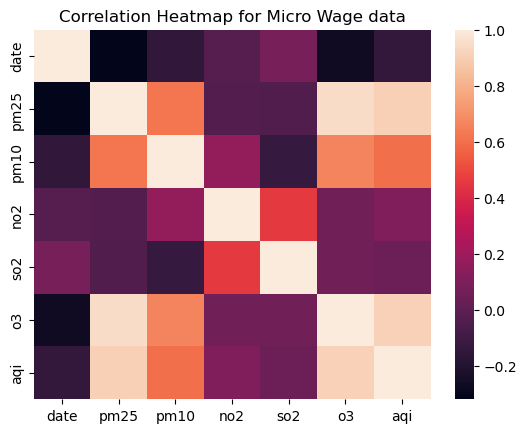

In [177]:
sns.heatmap(air_quality2.corr())
plt.title('Correlation Heatmap for Micro Wage data')
plt.show()

In [178]:
air_quality2['quality']=""
air_quality2.head()

,date,pm25,pm10,no2,so2,o3,aqi,quality
0,2022-01-13,355.4,61.3,24.3,75.1,370.0,230.5,
1,2022-01-14,308.7,54.4,22.5,64.8,365.0,191.5,
2,2022-01-15,309.9,52.5,19.1,59.7,352.0,177.7,
3,2022-01-16,231.0,46.9,19.1,54.0,278.0,133.6,
4,2022-01-17,353.6,47.9,14.5,64.1,350.0,235.1,


In [199]:
#air_quality2[air_quality2['aqi']<50]
air_quality2.loc[air_quality2['aqi']<=50, 'quality'] = 1
air_quality2.loc[(air_quality2['aqi']<=100) & (air_quality2['aqi']>50), 'quality'] = 2
air_quality2.loc[(air_quality2['aqi']>100) & (air_quality2['aqi']<=150), 'quality'] = 3
air_quality2.loc[(air_quality2['aqi']>150) & (air_quality2['aqi']<=200), 'quality'] = 4
air_quality2.loc[(air_quality2['aqi']>200) & (air_quality2['aqi']<=300), 'quality'] = 5
air_quality2.loc[(air_quality2['aqi']>300) & (air_quality2['aqi']<=500), 'quality'] = 6

In [200]:
air_quality2.head()

,date,pm25,pm10,no2,so2,o3,aqi,quality
0,2022-01-13,355.4,61.3,24.3,75.1,370.0,230.5,5
1,2022-01-14,308.7,54.4,22.5,64.8,365.0,191.5,4
2,2022-01-15,309.9,52.5,19.1,59.7,352.0,177.7,4
3,2022-01-16,231.0,46.9,19.1,54.0,278.0,133.6,3
4,2022-01-17,353.6,47.9,14.5,64.1,350.0,235.1,5


In [201]:
df=air_quality2
x=df.drop(["quality"],axis=1)
y=df["quality"]


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=50)

x_1=np.array(x_train.filter(['pm25','pm10','no2','so2','o3','aqi'],axis=1))

# 'occ_managprof', 'occ_service','occ_service_np', 'occ_service_broad'
x_test_arr=np.array(x_test.filter(['pm25','pm10','no2','so2','o3','aqi'],axis=1))



y_1=np.array(y_train)

regr = linear_model.LinearRegression()
regr.fit(x_1, y_1)
print(regr.intercept_, regr.coef_,regr.score(x_1, y_1))

y_predict = regr.predict(x_test_arr)




def regression_results(y_1, y_predict):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_test, y_predict)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_predict) 
    mse=metrics.mean_squared_error(y_test, y_predict) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_test, predicted)
    median_absolute_error=metrics.median_absolute_error(y_test, y_predict)
    r2=metrics.r2_score(y_test, y_predict)

    print('explained_variance is ', round(explained_variance,2))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2 is ', round(r2,4))
    print('MAE is ', round(mean_absolute_error,4))
    print('MSE is ', round(mse,4))
    print('RMSE is', round(np.sqrt(mse),4))
    

def predicted_plot(y_test, y_predict):
    plt.subplots(figsize=(8,6))
    plt.scatter(y_test, y_predict)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
    plt.xlabel("Actual Air Quality")
    plt.ylabel("Predicted Air quality")
    plt.title("Actual vs. Predicted Air Quality")
    plt.show()
    
def residual_plot(y_test, y_predict):
    residual_value = y_test - y_predict
    plt.figure(figsize=(8,6))
    sns.residplot(x=y_predict, y=residual_value ,scatter_kws={"color": "green"})
    plt.title("Plotting Residuals")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual values")
    plt.show()
    return residual_value

def probability_plot(residual):
    plt.subplots(figsize=(8,6))
    stats.probplot(residual, plot=plt)
    plt.title('Plotting Probability')
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('residual quantiles')
   
    plt.show()
    
regression_results(y_test,y_predict)


1.683971997953156 [-9.27944681e-05 -1.05740633e-03 -2.15392646e-04 -2.32936386e-03
 -7.98700526e-04  1.41088415e-02] 0.8448446590321695
explained_variance is  0.83
r2 is  0.8346
MAE is  0.2695
MSE is  0.1075
RMSE is 0.3279


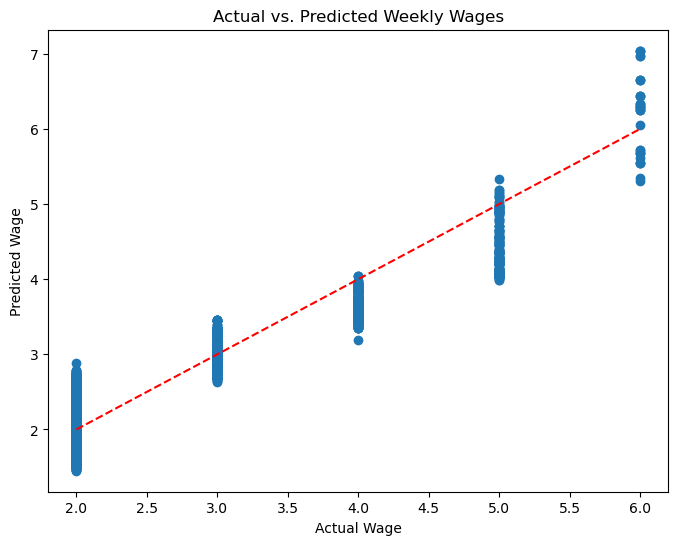

In [202]:
predicted_plot(y_test,y_predict)

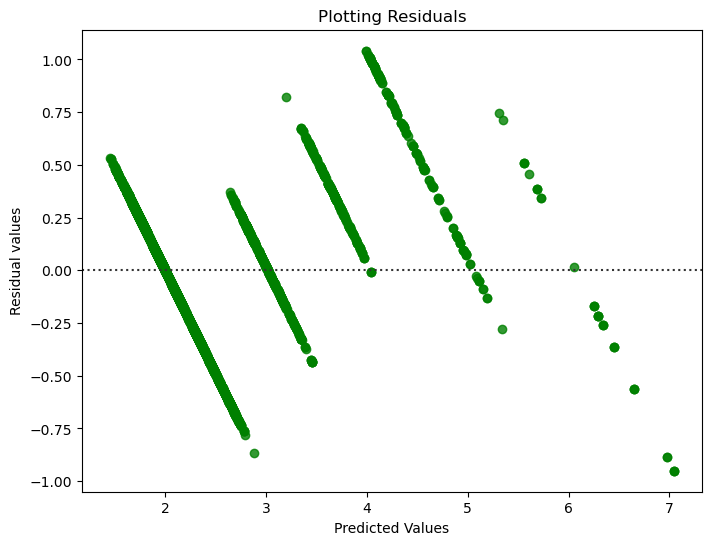

In [205]:
residuals=residual_plot(y_test,y_predict)

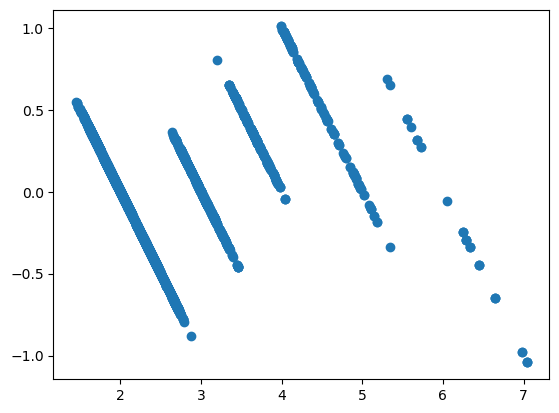

In [211]:
import matplotlib.pyplot as plt

# Assuming 'residual' is a single float value
# Replace 'residual' with your actual float value

# Create a scatter plot of the single float value
plt.scatter(y_predict,residuals) 